In [1]:
#Importing necessary function and packages
from keras.models import load_model
import numpy as np
from functools import wraps

import numpy as np
import tensorflow as tf
from keras import backend as K
from keras.layers import (
    Conv2D,
    Add,
    ZeroPadding2D,
    UpSampling2D,
    Concatenate,
    MaxPooling2D,
)
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.regularizers import l2

Using TensorFlow backend.


In [2]:
#Defining path for to access the weights obtained from Trainingg the yolo model on "fidget spinner"
#After training phase we obtained "trained_weights_final.h5"
model_weights_path = "C:\\Users\\lenovo\\DATA_TRAINED\\TrainYourOwnYOLO-master\\TrainYourOwnYOLO-master\\Data\Model_Weights\\trained_weights_final.h5"

#Defining the paths to access the "data_classes.txt" file which contains classes on which our model is trained
model_classes_path ="C:\\Users\\lenovo\DATA_TRAINED\\TrainYourOwnYOLO-master\\TrainYourOwnYOLO-master\\Data\\Model_Weights\\data_classes.txt"

#Defining the path to access the "yolo_anchors.txt" which contains predefined anchors to be used for YOLO
anchors_path="C:\\Users\\lenovo\\DATA_TRAINED\\TrainYourOwnYOLO-master\\TrainYourOwnYOLO-master\\2_Training\\src\\keras_yolo3\\model_data\\yolo_anchors.txt"

In [3]:
#Importing necessary functions reuired for predictions from our yolo_helper
from Training_own_yolo.yolo_helper import yolo_body, yolo_eval,get_classes,get_anchors

In [4]:
class_names = get_classes(model_classes_path) #this step will read classes in "data_classes.txt" and store it as list
num_classes = len(class_names) # getting number of classes

#This step will read anchors from "yolo_anchors.txt" file and store it in numpy array of shape(9,2)
anchors = get_anchors(anchors_path) 

num_anchors = len(anchors)

In [5]:
"""
This function will take directory path and get the path of all files which have one of the following
extensions ".jpg", ".jpeg", ".png", ".mp4"

"""
def GetFileList(dirName, endings=[".jpg", ".jpeg", ".png", ".mp4"]):
    # create a list of file and sub directories
    # names in the given directory
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Make sure all file endings start with a '.'

    for i, ending in enumerate(endings):
        if ending[0] != ".":
            endings[i] = "." + ending
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory
        if os.path.isdir(fullPath):
            allFiles = allFiles + GetFileList(fullPath, endings)
        else:
            for ending in endings:
                if entry.endswith(ending):
                    allFiles.append(fullPath)
    return allFiles

In [6]:
from keras.layers import Input

In [7]:
#"yolo_body" is the function which takes shape of the Input image ,number of anchors i.e 3 for Yolo(9/3),and number of classes
yolo_model=yolo_body(Input(shape=(None, None, 3)), num_anchors // 3, num_classes)

W0214 07:55:01.837373 11472 module_wrapper.py:139] From c:\users\lenovo\env\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0214 07:55:01.845350 11472 module_wrapper.py:139] From c:\users\lenovo\env\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0214 07:55:01.849349 11472 module_wrapper.py:139] From c:\users\lenovo\env\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0214 07:55:01.889339 11472 module_wrapper.py:139] From c:\users\lenovo\env\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0214 07:55:01.893361 11472 module_wrapper.py:139] From c:\users\lenovo\env\lib\site-packages\ke

In [8]:
#Here once we get the YOLO model architecture we are loading the weights "trained_weights_final.h5"
#"trained_weights_final.h5" this is the weights we obtained from our training phase
yolo_model.load_weights(model_weights_path)

In [9]:
#this is the function which will resize the image before passing to our "yolo_model"
def letterbox_image(image, size):
    """resize image with unchanged aspect ratio using padding"""
    iw, ih = image.size
    w, h = size
    scale = min(w / iw, h / ih)
    nw = int(iw * scale)
    nh = int(ih * scale)
    image = image.resize((nw, nh), Image.BICUBIC)
    new_image = Image.new("RGB", size, (128, 128, 128))
    new_image.paste(image, ((w - nw) // 2, (h - nh) // 2))
    return new_image

In [10]:
#Defining the image size to which any image need to be resized before passing to the model
model_image_size=(416,416)

In [11]:
from timeit import default_timer as timer
#This function is taking only image as an input
#This function returns prediction in the form of list which contains bounding box coordinates,label and confidence of prediction
def detect_image(image, show_stats=True):
    start = timer()

    # "model_image_size" is (416,416) what we defined in above block
    # "boxed_image" will contain resized image
    boxed_image = letterbox_image(image, tuple(reversed(model_image_size)))
    
    #Converting the image into numpy array
    image_data = np.array(boxed_image, dtype="float32")
    if show_stats:
        print(image_data.shape)
    
    #Normalizing the pixel values i.e between "0 & 1"
    image_data /= 255.0
    
    #Expanding the dimension i.e converting "(416,416,3)"  to "(1,416,416,3)" 
    image_data = np.expand_dims(image_data, 0)  # Add batch dimension.
    
    #Defining place holder for "input_image_shape"
    input_image_shape = K.placeholder(shape=(2,))
    
    #yolo_eval is the function which takes following as arguments
    """
    1)yolo_model.output--> list of output layers
    2)anchors we obtained from "yolo_anchors.txt" file
    3)Number of classes
    4)input_image_shape--This is passed as place holder and later we will feed the shape
    5)maximum number of boxes
    6)class_threshold i.e to consider detection as correct only if score is above this threshold
    7iou_threshold required for non max suppression
    
    """
    boxes,scores,classes=yolo_eval(yolo_model.output,anchors,len(class_names),input_image_shape,20,0.6,0.45)
    
    #This step actually getting the output and filling the place holders(Doubt)
    out_boxes, out_scores, out_classes = K.get_session().run(
            [boxes, scores, classes],
            feed_dict={
                yolo_model.input: image_data,
                input_image_shape: [image.size[1], image.size[0]],
                K.learning_phase(): 0,
            },
        )
    out_prediction = []
    for i, c in reversed(list(enumerate(out_classes))):
        predicted_class = class_names[c]
        box = out_boxes[i]
        score = out_scores[i]
        label = "{} {:.2f}".format(predicted_class, score)
        top, left, bottom, right = box
        top = max(0, np.floor(top + 0.5).astype("int32"))
        left = max(0, np.floor(left + 0.5).astype("int32"))
        bottom = min(image.size[1], np.floor(bottom + 0.5).astype("int32"))
        right = min(image.size[0], np.floor(right + 0.5).astype("int32"))
        if bottom==image.size[1]:
            bottom=bottom-50
        if right==image.size[0]:
            right=right-50
        out_prediction.append([left, top, right, bottom, c, score])
    end = timer()
    if show_stats:
        print("Time spent: {:.3f}sec".format(end - start))
    return out_prediction

In [12]:
from PIL import Image, ImageFont, ImageDraw
def detect_object(img_path):
    """
    This function accesses the image path and reads it and passes the image to "detect_image" function
    defined above

    """
    try:
        image = Image.open(img_path)
        if image.mode != "RGB":
            image = image.convert("RGB")
        image_array = np.array(image)
    except:
        print("File Open Error! Try again!")
        return None, None
    prediction= detect_image(image)
    return prediction, image_array

In [13]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [14]:
import os
image_file_list=GetFileList("C:\\Users\\lenovo\\DATA_TRAINED\\TrainYourOwnYOLO-master\\TrainYourOwnYOLO-master\\Data\\Source_Images\\Test_Images")

In [15]:
from PIL import Image

(416, 416, 3)


W0214 07:56:13.087689 11472 deprecation.py:323] From c:\users\lenovo\env\lib\site-packages\tensorflow_core\python\ops\array_ops.py:1475: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Time spent: 3.949sec
[[0, 127, 739, 528, 0, 0.90363103]]


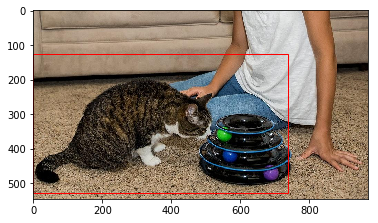

(416, 416, 3)
Time spent: 3.372sec
[[156, 0, 1010, 560, 0, 0.6023566]]


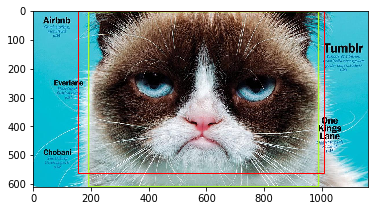

(416, 416, 3)
Time spent: 3.983sec
[[0, 0, 175, 224, 0, 0.99878335]]


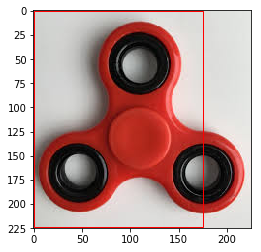

(416, 416, 3)
Time spent: 3.982sec
[[145, 91, 220, 192, 0, 0.7319808], [134, 4, 211, 88, 0, 0.73480576]]


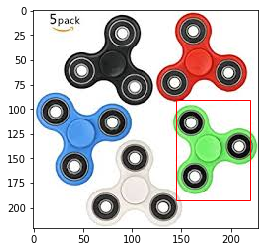

[[145, 91, 220, 192, 0, 0.7319808], [134, 4, 211, 88, 0, 0.73480576]]


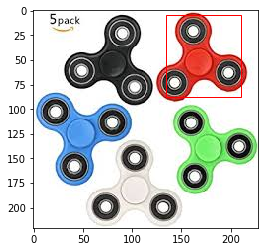

(416, 416, 3)
Time spent: 3.762sec
[[11, 7, 233, 177, 0, 0.99752307]]


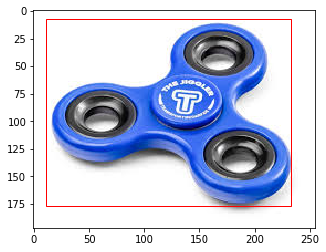

(416, 416, 3)
Time spent: 4.378sec
[[13, 21, 129, 125, 0, 0.9825245]]


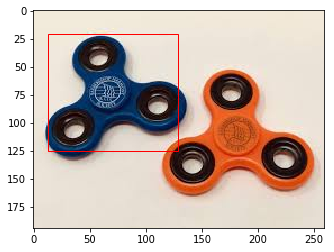

(416, 416, 3)
Time spent: 3.830sec
[[0, 0, 54, 54, 0, 0.9986603]]


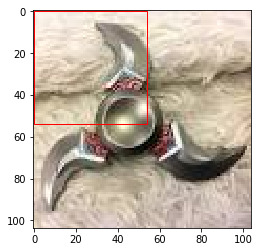

In [16]:
for list_item in image_file_list:
    prediction,image_array=detect_object(list_item)
    for i in range(len(prediction)):
        plt.imshow(image_array)
        ax=plt.gca()
        print(prediction)
        rect=Rectangle((prediction[i][0],prediction[i][1]),prediction[i][2]-prediction[i][0],prediction[i][3]-prediction[i][1],linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
        plt.show(block=True)
#Here in below output some fidget spinners are not identified as we have set class_threshold as 0.6
#Class_threshold is passed as 0.6 in yolo_eval which veing called in "detect_image" function

#Lets do the fidget spinner detection in videos

In [17]:
import cv2
import numpy as np
cap=cv2.VideoCapture("C:\\Users\\lenovo\\DATA_TRAINED\\Fidget Spinner - 11790.mp4")
while True:
    ret,frame=cap.read()
    if np.sum(frame)==None:
        break
    # opencv images are BGR, translate to RGB
    frame1 = frame[:, :, ::-1]
    image = Image.fromarray(frame1)
    out_pred= detect_image(image, show_stats=False)
    for i in range(len(out_pred)):
        cv2.rectangle(frame, (out_pred[i][0],out_pred[i][1]), (out_pred[i][2],out_pred[i][3]), (0, 255, 0), 2)
    print(out_pred)
    cv2.imshow("frame",frame)
    if cv2.waitKey(1)==27:
        break
cap.release()
cv2.destroyAllWindows()

[[0, 25, 1142, 464, 0, 0.83427274], [571, 222, 1870, 1030, 0, 0.9122703]]
[[98, 30, 1179, 520, 0, 0.7617834], [681, 328, 1870, 1041, 0, 0.9570972]]
[[0, 0, 1025, 531, 0, 0.81861], [938, 225, 1843, 1030, 0, 0.99013406]]
[[0, 21, 1118, 492, 0, 0.8483559], [588, 229, 1870, 1030, 0, 0.95440996]]
[[76, 0, 1199, 554, 0, 0.6942739], [672, 332, 1906, 1014, 0, 0.9742964]]
[[0, 0, 1057, 545, 0, 0.688841], [952, 239, 1827, 1030, 0, 0.98611355]]
